<a href="https://colab.research.google.com/github/crlotwhite/ML_Study/blob/main/%EB%85%BC%EB%AC%B8%EA%B5%AC%ED%98%84/cv/%5B2021%5D_AN_IMAGE_IS_WORTH_16X16_WORDS_TRANSFORMERS_FOR_IMAGE_RECOGNITION_AT_SCALE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

os.environ['KERAS_BACKEND'] = 'jax'

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

x_train.shape, y_train.shape, x_test.shape, y_test.shape

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [2048, 1024]


In [4]:
data_augmentation = keras.Sequential([
    layers.Normalization(),
    layers.Resizing(image_size, image_size),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=0.02),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
], name='data_augmentation')

# 정규화를 위해 훈련 데이터의 평균과 분산을 계산
data_augmentation.layers[0].adapt(x_train)


In [5]:
# ViT 논문 4페이지; 2개의 레이어와 gelu
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)

    return x

In [6]:
# 이미지를 패치로 나누기 위한 레이어 (3.1)
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()

        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]

        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = ops.image.extract_patches(images, size=self.patch_size)

        # N * (P^2 - C)
        patches = ops.reshape(
            patches, (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels
                )
            )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({'patch_size': self.patch_size})
        return config

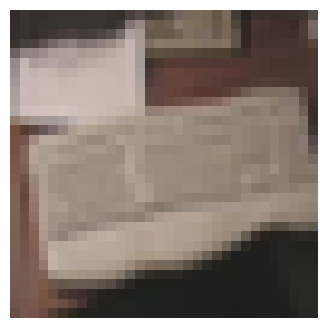

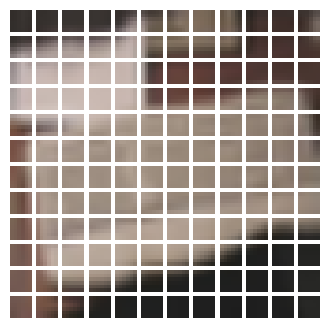

In [7]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]),
    size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")


In [8]:
# Transformer에 입력하기 위해 평탄화 + D 차원 매핑 + 위치 임베딩
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()

        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(ops.arange(start=0, stop=self.num_patches, step=1), axis=0)
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({'num_patches': self.num_patches})
        return config

In [9]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)

    # 데이터 증강
    augmented = data_augmentation(inputs)

    # Patch 나누기
    patches = Patches(patch_size)(augmented)

    # Patch Embedding
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer Encoder Layers
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads,
                                                     key_dim=projection_dim,
                                                     dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    # 인코더 결과물을 후처리하기위한 과정
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    outputs = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



In [10]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate,
                                       weight_decay=weight_decay)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = '/checkpoint.weights.h5'
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    return history

In [11]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.0275 - loss: 4.9053 - top-5-accuracy: 0.1083 - val_accuracy: 0.1042 - val_loss: 3.9486 - val_top-5-accuracy: 0.2958
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.0795 - loss: 4.0495 - top-5-accuracy: 0.2574 - val_accuracy: 0.1454 - val_loss: 3.6209 - val_top-5-accuracy: 0.3936
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.1185 - loss: 3.7651 - top-5-accuracy: 0.3426 - val_accuracy: 0.1974 - val_loss: 3.3868 - val_top-5-accuracy: 0.4630
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.1458 - loss: 3.5930 - top-5-accuracy: 0.3918 - val_accuracy: 0.2086 - val_loss: 3.2641 - val_top-5-accuracy: 0.4994
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.1715 - loss: 3.4460 - top-5-accuracy: 0.4381 - val_accuracy: 0.2360 - val_loss: 3.1127 - val_top-5-accuracy: 0.5250
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.1884 - loss: 3.333

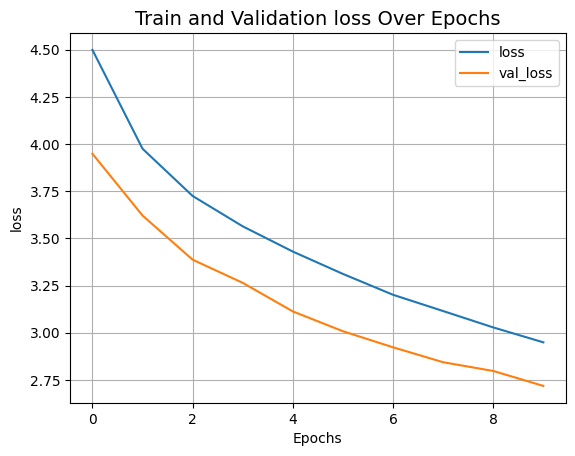

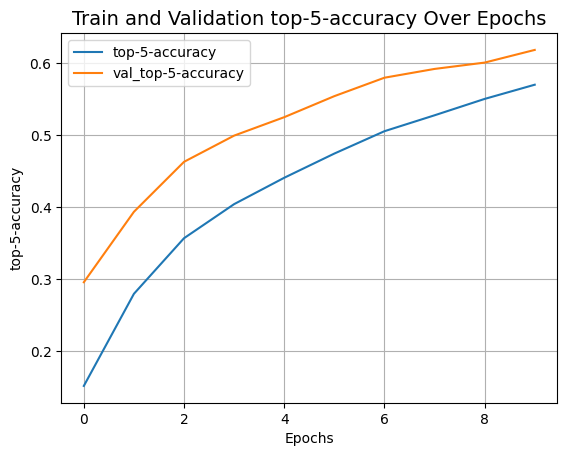

In [12]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")